## Q2:

**For each subway line and month, how many delay-causing incidents occurred, and how did it impact additional wait time for riders?**

In [11]:
import pandas as pd

delayed_df = pd.read_csv("../raw_data/delayed.csv")
delayed_df

,month,division,line,day_type,incidents,reporting_category
0,2024-01-01T00:00:00.000,A DIVISION,1,1,0,NaN
1,2024-01-01T00:00:00.000,A DIVISION,1,1,31,Crew Availability
2,2024-01-01T00:00:00.000,A DIVISION,1,1,2,External Factors
3,2024-01-01T00:00:00.000,A DIVISION,1,1,92,Infrastructure & Equipment
4,2024-01-01T00:00:00.000,A DIVISION,1,1,86,Operating Conditions
...,...,...,...,...,...,...
3761,2024-12-01T00:00:00.000,B DIVISION,S Rock,2,16,External Factors
3762,2024-12-01T00:00:00.000,B DIVISION,S Rock,2,6,Infrastructure & Equipment
3763,2024-12-01T00:00:00.000,B DIVISION,S Rock,2,1,Operating Conditions
3764,2024-12-01T00:00:00.000,B DIVISION,S Rock,2,1,Planned ROW Work


In [12]:
#copying over the data cleaning from the Data_Collection_Cleaning file
delayed_df = pd.read_csv("../raw_data/delayed.csv")

delayed_df = delayed_df.dropna()

delayed_df['month'] = pd.to_datetime(delayed_df['month']).dt.normalize()
delayed_df['division'] = delayed_df['division'].astype(str)
delayed_df['line'] = delayed_df['line'].astype(str)
delayed_df['day_type'] = delayed_df['day_type'].astype(str)
delayed_df['incidents'] = delayed_df['incidents'].astype(int)
delayed_df['reporting_category'] = delayed_df['reporting_category'].astype(str)

delayed_df['division'] = delayed_df['division'].str.strip().str.upper()
delayed_df['line'] = delayed_df['line'].str.strip().str.upper()
delayed_df['day_type'] = delayed_df['day_type'].str.strip().str.upper()
delayed_df['reporting_category'] = delayed_df['reporting_category'].str.strip().str.upper()

delayed_df

,month,division,line,day_type,incidents,reporting_category
1,2024-01-01,A DIVISION,1,1,31,CREW AVAILABILITY
2,2024-01-01,A DIVISION,1,1,2,EXTERNAL FACTORS
3,2024-01-01,A DIVISION,1,1,92,INFRASTRUCTURE & EQUIPMENT
4,2024-01-01,A DIVISION,1,1,86,OPERATING CONDITIONS
5,2024-01-01,A DIVISION,1,1,49,PLANNED ROW WORK
...,...,...,...,...,...,...
3761,2024-12-01,B DIVISION,S ROCK,2,16,EXTERNAL FACTORS
3762,2024-12-01,B DIVISION,S ROCK,2,6,INFRASTRUCTURE & EQUIPMENT
3763,2024-12-01,B DIVISION,S ROCK,2,1,OPERATING CONDITIONS
3764,2024-12-01,B DIVISION,S ROCK,2,1,PLANNED ROW WORK


In [14]:
metrics_df = pd.read_csv("../raw_data/metrics.csv")

metrics_df = metrics_df.dropna()

metrics_df['month'] = pd.to_datetime(metrics_df['month']).dt.normalize()
metrics_df['division'] = metrics_df['division'].astype(str)
metrics_df['line'] = metrics_df['line'].astype(str)
metrics_df['period'] = metrics_df['period'].astype(str)
metrics_df['num_passenger'] = metrics_df['num_passengers'].astype(float)
metrics_df['additional_platform_time'] = metrics_df['additional_platform_time'].astype(float)
metrics_df['additional_train_time'] = metrics_df['additional_train_time'].astype(float)
metrics_df['total_apt'] = metrics_df['total_apt'].astype(float)
metrics_df['total_att'] = metrics_df['total_att'].astype(float)
metrics_df['over_five_mins'] = metrics_df['over_five_mins'].astype(float)
metrics_df['over_five_mins_perc'] = metrics_df['over_five_mins_perc'].astype(float)
metrics_df['customer_journey_time'] = metrics_df['customer_journey_time'].astype(float)

metrics_df['line'] = metrics_df['line'].str.strip().str.upper()
metrics_df['division'] = metrics_df['division'].str.strip().str.upper()
metrics_df['period'] = metrics_df['period'].str.strip().str.upper()

metrics_df

,month,division,line,period,num_passengers,additional_platform_time,additional_train_time,total_apt,total_att,over_five_mins,over_five_mins_perc,customer_journey_time,num_passenger
0,2024-01-01,A DIVISION,1,OFFPEAK,4873143.500,1.656052,0.796657,8.070179e+06,3882225.200,763100.9000,0.156593,0.843407,4873143.500
1,2024-01-01,A DIVISION,1,PEAK,4765373.000,2.115036,0.873300,1.007894e+07,4161600.200,743524.6000,0.156027,0.843973,4765373.000
2,2024-01-01,A DIVISION,2,OFFPEAK,2878163.800,1.606833,0.501318,4.624728e+06,1442874.900,487204.1000,0.169276,0.830724,2878163.800
3,2024-01-01,A DIVISION,2,PEAK,3092725.500,2.073322,0.561746,6.412216e+06,1737327.100,460791.2000,0.148992,0.851008,3092725.500
4,2024-01-01,A DIVISION,3,OFFPEAK,2125353.800,1.249190,0.328101,2.654971e+06,697329.800,265963.7000,0.125139,0.874861,2125353.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,2024-12-01,B DIVISION,S FKLN,PEAK,194189.340,0.570730,0.057167,1.108297e+05,11101.285,9461.5890,0.048724,0.951276,194189.340
572,2024-12-01,B DIVISION,S ROCK,OFFPEAK,26513.352,1.262324,-0.908065,3.346844e+04,-24075.834,3445.4740,0.129952,0.870048,26513.352
573,2024-12-01,B DIVISION,S ROCK,PEAK,19257.482,0.878703,-1.183044,1.692160e+04,-22782.447,1812.6135,0.094125,0.905875,19257.482
574,2024-12-01,B DIVISION,W,OFFPEAK,1265461.600,0.938558,0.257632,1.187710e+06,326022.940,142330.0200,0.112473,0.887527,1265461.600


In [7]:
!pip install duckdb

In [ ]:
import duckdb

In [16]:
result = duckdb.query("""
    SELECT
        d.line,
        d.month,
        d.total_incidents,
        m.total_apt,
        m.total_passengers,
        m.avg_additional_platform_time
    FROM (
        -- incidents by line + month
        SELECT
            line,
            month,
            SUM(incidents) AS total_incidents
        FROM delayed_df
        GROUP BY line, month
    ) AS d
    JOIN (
        -- metrics by line + month
        SELECT
            line,
            month,
            SUM(total_apt) AS total_apt,
            SUM(num_passengers) AS total_passengers,
            SUM(num_passengers * additional_platform_time)
                / SUM(num_passengers) AS avg_additional_platform_time
        FROM metrics_df
        GROUP BY line, month
    ) AS m
      ON d.line = m.line
     AND d.month = m.month
    ORDER BY d.line, d.month;
""").to_df()

result


,line,month,total_incidents,total_apt,total_passengers,avg_additional_platform_time
0,1,2024-01-01,401.0,1.814911e+07,9638516.500,1.882978
1,1,2024-02-01,429.0,1.049535e+07,8230996.500,1.275100
2,1,2024-03-01,375.0,8.006230e+06,7250264.400,1.104267
3,1,2024-04-01,351.0,1.497941e+07,9816352.500,1.525965
4,1,2024-05-01,382.0,1.164673e+07,9323154.000,1.249227
...,...,...,...,...,...,...
271,S ROCK,2024-08-01,63.0,7.400709e+04,66214.000,1.117696
272,S ROCK,2024-09-01,64.0,5.347976e+04,53325.029,1.002902
273,S ROCK,2024-10-01,76.0,6.348731e+04,60941.944,1.041767
274,S ROCK,2024-11-01,35.0,4.950383e+04,56195.335,0.880924


In [31]:
#correlation coefficient
result[['total_incidents', 'avg_additional_platform_time']].corr()

,total_incidents,avg_additional_platform_time
total_incidents,1.000000,0.383911
avg_additional_platform_time,0.383911,1.000000


In [54]:
#range for time (for the interated dataset)
min_time = result['avg_additional_platform_time'].min()
max_time = result['avg_additional_platform_time'].max()

range = max_time - min_time
print("min time:", min_time)
print("max time:", max_time)
print("time range:", range)

min time: 0.24710305934529728
max time: 2.4285122400426555
time range: 2.1814091806973583


In [55]:
#mix and max wait times for the metrics_df alone (before integration, no averaging)
print("min time (none average):", metrics_df['additional_platform_time'].min())
print("max time (none average):", metrics_df['additional_platform_time'].max())

min time (none average): 0.220359
max time (none average): 2.9344876


## Data Visualization

In [29]:
import matplotlib.pyplot as plt

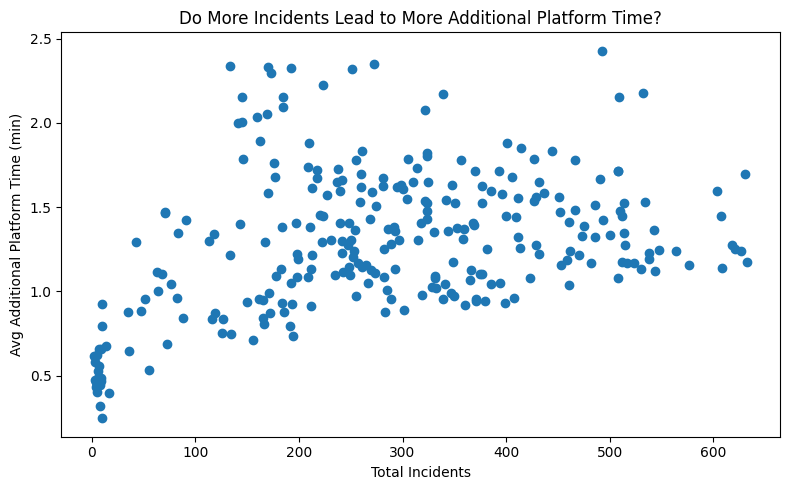

In [30]:
plt.figure(figsize=(8,5))
plt.scatter(result['total_incidents'], result['avg_additional_platform_time'])
plt.xlabel("Total Incidents")
plt.ylabel("Avg Additional Platform Time (min)")
plt.title("Do More Incidents Lead to More Additional Platform Time?")
plt.tight_layout()
plt.show()

## Data Analysis

For this question, we are looking to see the relationship: "Do more incidents lead to more additional platform wait time?". Based on the data, there is little evidence that a higher number of incidents leads to significantly longer additional platform wait times. The data shows only a weak relationship between incidents and additional platform wait time. The correlation is about 0.3, which means the number of incidents explains very little of the variation in wait times.

We also calculated the range for average additional platform time (wait time). 
Even though the numerical range looks large (0.25 to 2.43 minutes), the actual difference is small in real-world terms— about 2 minutes. This suggests that even when incident counts rise, rider wait times don’t increase much.

These results are surprising, because in personal experience, transit delays can last much longer (up to hours). This suggests the dataset may be limited or not fully capturing severe delay events. What makes these time averages and correlation coefficient more skeptical is that we expected averaging the additional_platform_time column to hide any unusually high or low wait times, but even in the original metrics_df, the minimum and maximum values are only 0.22 and 2.9 minutes, respectively. Looking at the data documentation, the "additional_platform_time" is "an average estimated additional time in minutes", these averages potentially hiding super long wait times. 
